# k-means with text data

In this assignment you will
* Cluster Wikipedia documents using k-means
* Explore the role of random initialization on the quality of the clustering
* Explore how results differ after changing the number of clusters
* Evaluate clustering, both quantitatively and qualitatively

When properly executed, clustering uncovers valuable insights from a set of unlabeled documents.

**Note to Amazon EC2 users**: To conserve memory, make sure to stop all the other notebooks before running this notebook.

## Import necessary packages

The following code block will check if you have the correct version of GraphLab Create. Any version later than 1.8.5 will do. To upgrade, read [this page](https://turi.com/download/upgrade-graphlab-create.html).

In [3]:
import sys
import os

import graphlab
from graphlab._gl_pickle import GLPickler
from graphlab._gl_pickle import GLUnpickler

import matplotlib.pyplot as plt
import numpy
from scipy.sparse import csr_matrix
import seaborn

%matplotlib inline

'''Check GraphLab Create version'''
from distutils.version import StrictVersion
assert (StrictVersion(graphlab.version) >= StrictVersion('1.8.5')), 'GraphLab Create must be version 1.8.5 or later.'

/home/cronos/.virtualenvs/machinelearning/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


This non-commercial license of GraphLab Create for academic use is assigned to rsnakamura@acm.org and will expire on March 24, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.0.1 started. Logging: /tmp/graphlab_server_1470512733.log


A newer version of GraphLab Create (v2.1) is available! Your current version is v2.0.1.
You can use pip to upgrade the graphlab-create package. For more information see https://turi.com/products/create/upgrade.


In [64]:
# @hp only
HP_CORES = 40
NOT_HP = 2
graphlab.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', HP_CORES)

## Load data, extract features

To work with text data, we must first convert the documents into numerical features. As in the first assignment, let's extract TF-IDF features for each article.

In [65]:
wiki = graphlab.SFrame('../data/people_wiki.gl/')

In [66]:
# wiki['tf_idf'] = graphlab.text_analytics.tf_idf(wiki['text'])
tf_idf_path = '../data/tf_idf.pkl'
if os.path.isfile(tf_idf_path):
    unpickler = GLUnpickler(tf_idf_path)
    tf_idf_gl = unpickler.load()
else:
    tf_idf_gl = graphlab.text_analytics.tf_idf(wiki['text'])
    pickler = GLPickler(tf_idf_path)
    pickler.dump(tf_idf_gl)

wiki['tf_idf'] = tf_idf_gl
wiki

Columns:
	URI	str
	name	str
	text	str
	tf_idf	dict

Rows: 59071

Data:
+-------------------------------+---------------------+
|              URI              |         name        |
+-------------------------------+---------------------+
| <http://dbpedia.org/resour... |    Digby Morrell    |
| <http://dbpedia.org/resour... |    Alfred J. Lewy   |
| <http://dbpedia.org/resour... |    Harpdog Brown    |
| <http://dbpedia.org/resour... | Franz Rottensteiner |
| <http://dbpedia.org/resour... |        G-Enka       |
| <http://dbpedia.org/resour... |    Sam Henderson    |
| <http://dbpedia.org/resour... |    Aaron LaCrate    |
| <http://dbpedia.org/resour... |   Trevor Ferguson   |
| <http://dbpedia.org/resour... |     Grant Nelson    |
| <http://dbpedia.org/resour... |     Cathy Caruth    |
+-------------------------------+---------------------+
+-------------------------------+-------------------------------+
|              text             |             tf_idf            |
+------------

For the remainder of the assignment, we will use sparse matrices. Sparse matrices are matrices that have a small number of nonzero entries. A good data structure for sparse matrices would only store the nonzero entries to save space and speed up computation. SciPy provides a highly-optimized library for sparse matrices. Many matrix operations available for NumPy arrays are also available for SciPy sparse matrices.

We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format. We included plenty of comments for the curious; if you'd like, you may skip the next block and treat the function as a black box.

In [67]:
def sframe_to_scipy(x, column_name):
    '''
    Convert a dictionary column of an SFrame into a sparse matrix format where
    each (row_id, column_id, value) triple corresponds to the value of
    x[row_id][column_id], where column_id is a key in the dictionary.
       
    Example
    >>> sparse_matrix, map_key_to_index = sframe_to_scipy(sframe, column_name)
    '''
    assert x[column_name].dtype() == dict, \
        'The chosen column must be dict type, representing sparse data.'
        
    # Create triples of (row_id, feature_id, count).
    # 1. Add a row number.
    x = x.add_row_number()
    # 2. Stack will transform x to have a row for each unique (row, key) pair.
    x = x.stack(column_name, ['feature', 'value'])

    # Map words into integers using a OneHotEncoder feature transformation.
    f = graphlab.feature_engineering.OneHotEncoder(features=['feature'])
    # 1. Fit the transformer using the above data.
    f.fit(x)
    # 2. The transform takes 'feature' column and adds a new column 'feature_encoding'.
    x = f.transform(x)
    # 3. Get the feature mapping.
    mapping = f['feature_encoding']
    # 4. Get the feature id to use for each key.
    x['feature_id'] = x['encoded_features'].dict_keys().apply(lambda x: x[0])

    # Create numpy arrays that contain the data for the sparse matrix.
    i = numpy.array(x['id'])
    j = numpy.array(x['feature_id'])
    v = numpy.array(x['value'])
    width = x['id'].max() + 1
    height = x['feature_id'].max() + 1

    # Create a sparse matrix.
    mat = csr_matrix((v, (i, j)), shape=(width, height))

    return mat, mapping

In [68]:
# The conversion will take about a minute or two.
tf_idf, map_index_to_word = sframe_to_scipy(wiki, 'tf_idf')

In [69]:
tf_idf

<59071x547979 sparse matrix of type '<type 'numpy.float64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

The above matrix contains a TF-IDF score for each of the 59071 pages in the data set and each of the 547979 unique words.

## Normalize all vectors

As discussed in the previous assignment, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

We can prove this as follows. Let $\mathbf{x}$ and $\mathbf{y}$ be normalized vectors, i.e. unit vectors, so that $\|\mathbf{x}\|=\|\mathbf{y}\|=1$. Write the squared Euclidean distance as the dot product of $(\mathbf{x} - \mathbf{y})$ to itself:
\begin{align*}
\|\mathbf{x} - \mathbf{y}\|^2 &= (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y})\\
                              &= (\mathbf{x}^T \mathbf{x}) - 2(\mathbf{x}^T \mathbf{y}) + (\mathbf{y}^T \mathbf{y})\\
                              &= \|\mathbf{x}\|^2 - 2(\mathbf{x}^T \mathbf{y}) + \|\mathbf{y}\|^2\\
                              &= 2 - 2(\mathbf{x}^T \mathbf{y})\\
                              &= 2(1 - (\mathbf{x}^T \mathbf{y}))\\
                              &= 2\left(1 - \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}\right)\\
                              &= 2\left[\text{cosine distance}\right]
\end{align*}

This tells us that two **unit vectors** that are close in Euclidean distance are also close in cosine distance. Thus, the k-means algorithm (which naturally uses Euclidean distances) on normalized vectors will produce the same results as clustering using cosine distance as a distance metric.

We import the [`normalize()` function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) from scikit-learn to normalize all vectors to unit length.

In [70]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

## Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

**Note:** We specify a seed here, so that everyone gets the same answer. In practice, we highly recommend to use different seeds every time (for instance, by using the current timestamp).

In [71]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        numpy.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = numpy.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

In pseudocode, we iteratively do the following:
```
cluster_assignment = assign_clusters(data, centroids)
centroids = revise_centroids(data, k, cluster_assignment)
```

### Assigning clusters

How do we implement Step 1 of the main k-means loop above? First import `pairwise_distances` function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See [this documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.

In [72]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print dist

[[ 1.41000789  1.36894636]
 [ 1.40935215  1.41023886]
 [ 1.39855967  1.40890299]
 ..., 
 [ 1.41108296  1.39123646]
 [ 1.41022804  1.31468652]
 [ 1.39899784  1.41072448]]


More formally, `dist[i,j]` is assigned the distance between the `i`th row of `X` (i.e., `X[i,:]`) and the `j`th row of `Y` (i.e., `Y[j,:]`).

**Checkpoint:** For a moment, suppose that we initialize three centroids with the first 3 rows of `tf_idf`. Write code to compute distances from each of the centroids to all data points in `tf_idf`. Then find the distance between row 430 of `tf_idf` and the second centroid and save it to `dist`.

In [73]:
all_distances = pairwise_distances(tf_idf[:3,:], tf_idf)

In [74]:
# Students should write code here

#dist = pairwise_distances(tf_idf[430,:], tf_idf[1,:])
dist = all_distances[1][430]

In [75]:
'''Test cell'''
if numpy.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Next, given the pairwise distances, we take the minimum of the distances for each data point. Fittingly, NumPy provides an `argmin` function. See [this documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.argmin.html) for details.

Read the documentation and write code to produce a 1D array whose i-th entry indicates the centroid that is the closest to the i-th data point. Use the list of distances from the previous checkpoint and save them as `distances`. The value 0 indicates closeness to the first centroid, 1 indicates closeness to the second centroid, and so forth. Save this array as `closest_cluster`.

**Hint:** the resulting array should be as long as the number of data points.

In [76]:
# Students should write code here
distances = all_distances
closest_cluster = [numpy.argmin(d) for d in distances]
print(closest_cluster)


[0, 1, 2]


In [77]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if numpy.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


**Checkpoint:** Let's put these steps together.  First, initialize three centroids with the first 3 rows of `tf_idf`. Then, compute distances from each of the centroids to all data points in `tf_idf`. Finally, use these distance calculations to compute cluster assignments and assign them to `cluster_assignment`.

In [78]:
# Students should write code here
centroids = tf_idf[:3,:]
all_distances = pairwise_distances(tf_idf, centroids)
cluster_assignment = [numpy.argmin(d) for d in all_distances]

In [79]:
if len(cluster_assignment)==59071 and \
   numpy.array_equal(numpy.bincount(cluster_assignment), numpy.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


Now we are ready to fill in the blanks in this function:

In [80]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids)
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = [numpy.argmin(d) for d in distances_from_centroids]
    
    return numpy.array(cluster_assignment)

**Checkpoint**. For the last time, let us check if Step 1 was implemented correctly. With rows 0, 2, 4, and 6 of `tf_idf` as an initial set of centroids, we assign cluster labels to rows 0, 10, 20, ..., and 90 of `tf_idf`. The resulting cluster labels should be `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`.

In [81]:
if numpy.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), numpy.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


### Revising clusters

Let's turn to Step 2, where we compute the new centroids given the cluster assignments. 

SciPy and NumPy arrays allow for filtering via Boolean masks. For instance, we filter all data points that are assigned to cluster 0 by writing
```
data[cluster_assignment==0,:]
```

To develop intuition about filtering, let's look at a toy example consisting of 3 data points and 2 clusters.

In [82]:
data = numpy.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = numpy.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

Let's assign these data points to the closest centroid.

In [83]:
cluster_assignment = assign_clusters(data, centroids)
print cluster_assignment

[0 1 0]


The expression `cluster_assignment==1` gives a list of Booleans that says whether each data point is assigned to cluster 1 or not:

In [84]:
cluster_assignment==1

array([False,  True, False], dtype=bool)

Likewise for cluster 0:

In [85]:
cluster_assignment==0

array([ True, False,  True], dtype=bool)

In lieu of indices, we can put in the list of Booleans to pick and choose rows. Only the rows that correspond to a `True` entry will be retained.

First, let's look at the data points (i.e., their values) assigned to cluster 1:

In [86]:
data[cluster_assignment==1]

array([[ 0.,  0.,  0.]])

This makes sense since [0 0 0] is closer to [0 -0.5 0] than to [0.5 0.5 0].

Now let's look at the data points assigned to cluster 0:

In [87]:
data[cluster_assignment==0]

array([[ 1.,  2.,  0.],
       [ 2.,  2.,  0.]])

Again, this makes sense since these values are each closer to [0.5 0.5 0] than to [0 -0.5 0].

Given all the data points in a cluster, it only remains to compute the mean. Use [numpy.mean()](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.mean.html). By default, the function averages all elements in a 2D array. To compute row-wise or column-wise means, add the `axis` argument. See the linked documentation for details. 

Use this function to average the data points in cluster 0:

In [88]:
data[cluster_assignment==0].mean(axis=0)

array([ 1.5,  2. ,  0. ])

We are now ready to complete this function:

In [89]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in xrange(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = numpy.array(new_centroids)
    
    return new_centroids

**Checkpoint**. Let's check our Step 2 implementation. Letting rows 0, 10, ..., 90 of `tf_idf` as the data points and the cluster labels `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`, we compute the next set of centroids. Each centroid is given by the average of all member data points in corresponding cluster.

In [90]:
result = revise_centroids(tf_idf[0:100:10], 3, numpy.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if numpy.allclose(result[0], numpy.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   numpy.allclose(result[1], numpy.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   numpy.allclose(result[2], numpy.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


### Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [91]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in xrange(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += numpy.sum(squared_distances)
        
    return heterogeneity

Let's compute the cluster heterogeneity for the 2-cluster example we've been considering based on our current cluster assignments and centroids.

In [92]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics
* Stops if either no assignment changed or we reach a certain number of iterations.

In [93]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in xrange(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = numpy.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
                                    
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [94]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step.  Then, let's plot the heterogeneity over iterations using the plotting function above.

0


1


    19157 elements changed their cluster assignment.


2


     7739 elements changed their cluster assignment.


3


     5119 elements changed their cluster assignment.


4


     3370 elements changed their cluster assignment.


5


     2811 elements changed their cluster assignment.


6


     3233 elements changed their cluster assignment.


7


     3815 elements changed their cluster assignment.


8


     3172 elements changed their cluster assignment.


9


     1149 elements changed their cluster assignment.


10


      498 elements changed their cluster assignment.


11


      265 elements changed their cluster assignment.


12


      149 elements changed their cluster assignment.


13


      100 elements changed their cluster assignment.


14


       76 elements changed their cluster assignment.


15


       67 elements changed their cluster assignment.


16


       51 elements changed their cluster assignment.


17


       47 elements changed their cluster assignment.


18


       40 elements changed their cluster assignment.


19


       34 elements changed their cluster assignment.


20


       35 elements changed their cluster assignment.


21


       39 elements changed their cluster assignment.


22


       24 elements changed their cluster assignment.


23


       16 elements changed their cluster assignment.


24


       12 elements changed their cluster assignment.


25


       14 elements changed their cluster assignment.


26


       17 elements changed their cluster assignment.


27


       15 elements changed their cluster assignment.


28


       14 elements changed their cluster assignment.


29


       16 elements changed their cluster assignment.


30


       21 elements changed their cluster assignment.


31


       22 elements changed their cluster assignment.


32


       33 elements changed their cluster assignment.


33


       35 elements changed their cluster assignment.


34


       39 elements changed their cluster assignment.


35


       36 elements changed their cluster assignment.


36


       36 elements changed their cluster assignment.


37


       25 elements changed their cluster assignment.


38


       27 elements changed their cluster assignment.


39


       25 elements changed their cluster assignment.


40


       28 elements changed their cluster assignment.


41


       35 elements changed their cluster assignment.


42


       31 elements changed their cluster assignment.


43


       25 elements changed their cluster assignment.


44


       18 elements changed their cluster assignment.


45


       15 elements changed their cluster assignment.


46


       10 elements changed their cluster assignment.


47


        8 elements changed their cluster assignment.


48


        8 elements changed their cluster assignment.


49


        8 elements changed their cluster assignment.


50


        7 elements changed their cluster assignment.


51


        8 elements changed their cluster assignment.


52


        3 elements changed their cluster assignment.


53


        3 elements changed their cluster assignment.


54


        4 elements changed their cluster assignment.


55


        2 elements changed their cluster assignment.


56


        3 elements changed their cluster assignment.


57


        3 elements changed their cluster assignment.


58


        1 elements changed their cluster assignment.


59


        1 elements changed their cluster assignment.


60


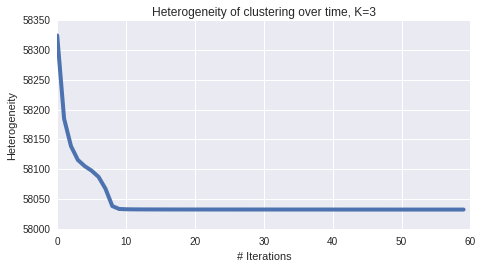

In [95]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

**Quiz Question**. (True/False) The clustering objective (heterogeneity) is non-increasing for this example.
True

**Quiz Question**. Let's step back from this particular example. If the clustering objective (heterogeneity) would ever increase when running k-means, that would indicate: (choose one)

1. k-means algorithm got stuck in a bad local minimum
2. There is a bug in the k-means code
3. All data points consist of exact duplicates
4. Nothing is wrong. The objective should generally go down sooner or later.

> Marked wrong 1. k-means algorithm got stuck in a bad local minimum
2. There is a bug in the k-means code

**Quiz Question**. Which of the cluster contains the greatest number of data points in the end? Hint: Use [`numpy.bincount()`](http://docs.scipy.org/doc/numpy-1.11.0/reference/generated/numpy.bincount.html) to count occurrences of each cluster label.
 1. Cluster #0
 2. Cluster #1
 3. Cluster #2

In [96]:
bin_counts = numpy.bincount(cluster_assignment)
numpy.argmax(numpy.bincount(cluster_assignment))

2

In [97]:
print(bin_counts[numpy.argmax(bin_counts)])
print(bin_counts[numpy.argmin(bin_counts)])

29049
10427


## Beware of local maxima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

**Note:** Again, in practice, you should set different seeds for every run. We give you a list of seeds for this assignment so that everyone gets the same answer.

This may take several minutes to run.

In [98]:
k = 10
heterogeneity = {}
import time
start = time.time()
biggests = []
smallests = []
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    seed_start = time.time()
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    counts = numpy.bincount(cluster_assignment)
    biggest = counts[numpy.argmax(counts)]
    smallest = counts[numpy.argmin(counts)]
    biggests.append(biggest)
    smallests.append(smallest)
    print('seed={0:06d}, heterogeneity={1:.5f}, smallest cluster={2}, largest cluster size={3}, time={4}'.format(seed, heterogeneity[seed],
                                                                                                                 smallest,
                                                                                                                 biggest,
                                                                                                                 seed_start-time.time()))
    sys.stdout.flush()
end = time.time()
print(end-start)
print("maximum cluster size: {0}".format(max(biggests)))
print("minimum cluster size: {0}".format(min(smallests)))

seed=000000, heterogeneity=57457.52442, smallest cluster=1492, largest cluster size=18047, time=-31.7630429268


seed=020000, heterogeneity=57533.20100, smallest cluster=768, largest cluster size=15779, time=-24.775398016


seed=040000, heterogeneity=57512.69257, smallest cluster=186, largest cluster size=18132, time=-24.5747890472


seed=060000, heterogeneity=57466.97925, smallest cluster=424, largest cluster size=17900, time=-20.1601550579


seed=080000, heterogeneity=57494.92990, smallest cluster=809, largest cluster size=17582, time=-72.8261260986


seed=100000, heterogeneity=57484.42210, smallest cluster=1337, largest cluster size=16969, time=-23.8191931248


seed=120000, heterogeneity=57554.62410, smallest cluster=1608, largest cluster size=16481, time=-41.5322189331


239.45937109
maximum cluster size: 18132
minimum cluster size: 186


Notice the variation in heterogeneity for different initializations. This indicates that k-means sometimes gets stuck at a bad local minimum.

**Quiz Question**. Another way to capture the effect of changing initialization is to look at the distribution of cluster assignments. Add a line to the code above to compute the size (# of member data points) of clusters for each run of k-means. Look at the size of the largest cluster (most # of member data points) across multiple runs, with seeds 0, 20000, ..., 120000. How much does this measure vary across the runs? What is the minimum and maximum values this quantity takes?

minimum cluster size = 186
maximum cluster size = 18132

One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime.

In [99]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        numpy.random.seed(seed)
    centroids = numpy.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = numpy.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()
    
    for i in xrange(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = numpy.random.choice(data.shape[0], 1, p=distances/sum(distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        distances = numpy.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean'),axis=1)
    
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

This may take several minutes to run.

In [100]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57441.33298


seed=020000, heterogeneity=57457.50383


seed=040000, heterogeneity=57469.82237


seed=060000, heterogeneity=57503.05355


seed=080000, heterogeneity=57464.05684


seed=100000, heterogeneity=57487.57010


seed=120000, heterogeneity=57534.79120


318.769531012


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a [box plot](http://matplotlib.org/api/pyplot_api.html) for each of these methods, indicating the spread of values produced by each method.

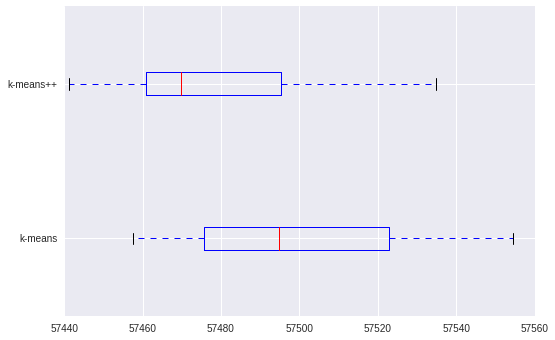

In [101]:
plt.figure(figsize=(8,5))
plt.boxplot([heterogeneity.values(), heterogeneity_smart.values()], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

A few things to notice from the box plot:
* Random initialization results in a worse clustering than k-means++ on average.
* The best result of k-means++ is better than the best result of random initialization.

**In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.** Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values.

In [102]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in xrange(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            numpy.random.seed(seed)
        else: 
            seed = int(time.time())
            numpy.random.seed(seed)
        
        # Use k-means++ initialization
        # YOUR CODE HERE
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means
        # YOUR CODE HERE
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter)
        
        # To save time, compute heterogeneity only once in the end
        # YOUR CODE HERE
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition.  For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. (Note: Not all runs for larger K will result in lower heterogeneity than a single run with smaller K due to local optima.)  Let's explore this general trend for ourselves by performing the following analysis.

Use the `kmeans_multiple_runs` function to run k-means with five different values of K.  For each K, use k-means++ and multiple runs to pick the best solution.  In what follows, we consider K=2,10,25,50,100 and 7 restarts for each setting.

**IMPORTANT: The code block below will take about one hour to finish. We highly suggest that you use the arrays that we have computed for you.**

Side note: In practice, a good implementation of k-means would utilize parallelism to run multiple runs of k-means at once. For an example, see [scikit-learn's KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [103]:
#def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
#    plt.figure(figsize=(7,4))
#    plt.plot(k_values, heterogeneity_values, linewidth=4)
#    plt.xlabel('K')
#    plt.ylabel('Heterogeneity')
#    plt.title('K vs. Heterogeneity')
#    plt.rcParams.update({'font.size': 16})
#    plt.tight_layout()

#start = time.time()
#centroids = {}
#cluster_assignment = {}
#heterogeneity_values = []
#k_list = [2, 10, 25, 50, 100]
#seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

#for k in k_list:
#    heterogeneity = []
#    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
#                                                               num_runs=len(seed_list),
#                                                               seed_list=seed_list,
#                                                               verbose=True)
#    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
#    heterogeneity_values.append(score)

#plot_k_vs_heterogeneity(k_list, heterogeneity_values)

#end = time.time()
#print(end-start)

To use the pre-computed NumPy arrays, first download kmeans-arrays.npz as mentioned in the reading for this assignment and load them with the following code.  Make sure the downloaded file is in the same directory as this notebook.

2


10


25


50


100


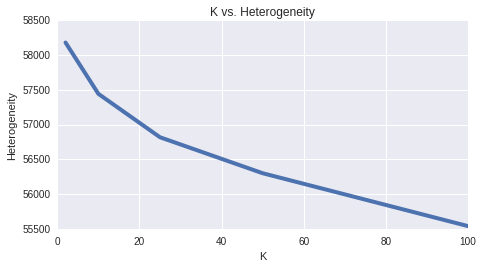

In [104]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = '../data/kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = numpy.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print k
        sys.stdout.flush()
        '''To save memory space, do not load the arrays from the file right away. We use
           a technique known as lazy evaluation, where some expressions are not evaluated
           until later. Any expression appearing inside a lambda function doesn't get
           evaluated until the function is called.
           Lazy evaluation is extremely important in memory-constrained setting, such as
           an Amazon EC2 t2.micro instance.'''
        centroids[k] = lambda k=k: arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = lambda k=k: arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k](), cluster_assignment[k]())
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

In the above plot we show that heterogeneity goes down as we increase the number of clusters. Does this mean we should always favor a higher K? **Not at all!** As we will see in the following section, setting K too high may end up separating data points that are actually pretty alike. At the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, but separating each data point into its own cluster is hardly a desirable outcome. In the following section, we will learn how to detect a K set "too large".

## Visualize clusters of documents

Let's start visualizing some clustering results to see if we think the clustering makes sense.  We can use such visualizations to help us assess whether we have set K too large or too small for a given application.  Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

What are we looking for in a good clustering of documents?
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
* Documents in a cluster have mixed content.
* Documents with similar content are divided up and put into different clusters.

To help visualize the clustering, we do the following:
* Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
* Print titles and first sentences of those nearest neighbors.
* Print top 5 words that have highest tf-idf weights in each centroid.

In [105]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in xrange(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in xrange(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word['category'][idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in xrange(8):
                text = ' '.join(wiki[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki[nearest_neighbors[i]]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

Let us first look at the 2 cluster case (K=2).

Notice the extra pairs of parentheses for centroids and cluster_assignment.
The centroid and cluster_assignment are still inside the npz file,
and we need to explicitly indicate when to load them into memory.

In [106]:
visualize_document_clusters(wiki, tf_idf, centroids[2](), cluster_assignment[2](), 2, map_index_to_word)

Cluster 0     she:0.025 her:0.017 music:0.012 he:0.011

 university:0.011 

* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working



* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical



* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda                                         0.97621
  jane fonda born lady jayne seymour fonda december 21 1937 is an american actress writer po
  litical activist former fashion model and fitness guru she is



* Christine Robertson                                0.97643
  christine mary robertson born 5 october 1948 is an australian politician and former austra
  lian labor party member of the new south wales legislative council serving

* Pat Studdy-Clift                                   0.97643
  pat studdyclift is an australian author specialising in historical fiction and nonfictionb
  orn in 1925 she lived in gunnedah until she was sent to a boarding



* Alexandra Potter                                   0.97646
  alexandra potter born 1970 is a british author of romantic comediesborn in bradford yorksh
  ire england and educated at liverpool university gaining an honors degree in
Cluster 1     league:0.040 season:0.036 team:0.029 football:0.029 played:0.028 

* Todd Williams                                      0.95468
  todd michael williams born february 13 1971 in syracuse new york is a former major league 
  baseball relief pitcher he attended east syracuseminoa high school



* Gord Sherven                                       0.95622
  gordon r sherven born august 21 1963 in gravelbourg saskatchewan and raised in mankota sas
  katchewan is a retired canadian professional ice hockey forward who played

* Justin Knoedler                                    0.95639
  justin joseph knoedler born july 17 1980 in springfield illinois is a former major league 
  baseball catcherknoedler was originally drafted by the st louis cardinals



* Chris Day                                          0.95648
  christopher nicholas chris day born 28 july 1975 is an english professional footballer who
   plays as a goalkeeper for stevenageday started his career at tottenham

* Tony Smith (footballer, born 1957)                 0.95653
  anthony tony smith born 20 february 1957 is a former footballer who played as a central de
  fender in the football league in the 1970s and



* Ashley Prescott                                    0.95761
  ashley prescott born 11 september 1972 is a former australian rules footballer he played w
  ith the richmond and fremantle football clubs in the afl between

* Leslie Lea                                         0.95802
  leslie lea born 5 october 1942 in manchester is an english former professional footballer 
  he played as a midfielderlea began his professional career with blackpool



* Tommy Anderson (footballer)                        0.95818
  thomas cowan tommy anderson born 24 september 1934 in haddington is a scottish former prof
  essional footballer he played as a forward and was noted for


Both clusters have mixed content, although cluster 1 is much purer than cluster 0:
* Cluster 0: artists, songwriters, professors, politicians, writers, etc.
* Cluster 1: baseball players, hockey players, football (soccer) players, etc.

Top words of cluster 1 are all related to sports, whereas top words of cluster 0 show no clear pattern.

Roughly speaking, the entire dataset was divided into athletes and non-athletes. It would be better if we sub-divided non-athletes into more categories. So let us use more clusters. How about `K=10`?

In [107]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k, map_index_to_word)

Cluster 0    

 art:0.013 he:0.012 book:0.010 his:0.009 that:0.009 



* Wilson McLean                                      0.97609
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art



* Tang Xiyang                                        0.97913
  tang xiyang born january 30 1930 in miluo hunan province is a chinese environmentalist he 
  was awarded the 2007 ramon magsaysay award for peace and

* David Salle                                        0.98020
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned



* Alberto Blanco (poet)                              0.98051
  alberto blanco is considered one of mexicos most important poets born in mexico city on fe
  bruary 18 1951 he spent his childhood and adolescence in



* David Elliott (curator)                            0.98159
  david stuart elliott born 29 april 1949 is a britishborn art gallery and museum curator an
  d writer about modern and contemporary arthe was educated at

* John Walker (painter)                              0.98217
  john walker born 1939 is an english painter and printmaker he has been called one of the s
  tandout abstract painters of the last 50 yearswalker



* Larry Woiwode                                      0.98227
  larry alfred woiwode born october 30 1941 is an american writer who lives in north dakota 
  where he has been the states poet laureate since



* Robert Fleming (author)                            0.98231
  robert fleming is a journalist and writer of erotic fiction and horror fiction he is also 
  a contributing editor for black issues book review he
Cluster 1    

 film:0.089 theatre:0.037 films:0.032 television:0.028 actor:0.027 

* Shona Auerbach                                     0.93472
  shona auerbach is a british film director and cinematographerauerbach began her career as 
  a stills photographer she studied film at manchester university and cinematography at



* Singeetam Srinivasa Rao                            0.93674
  singeetam srinivasa rao born 21 september 1931 is an indian film director producer screenw
  riter composer singer lyricist and actor known for his works in telugu

* Justin Edgar                                       0.93738
  justin edgar is a british film directorborn in handsworth birmingham on 18 august 1971 edg
  ar graduated from portsmouth university in 1996 with a first class



* Laura Neri                                         0.94106
  laura neri greek is a director of greek and italian origins born in brussels belgium she g
  raduated from the usc school of cinematic arts in

* Bill Bennett (director)                            0.94206
  bill bennett born 1953 is an australian film director producer and screenwriterhe dropped 
  out of medicine at queensland university in 1972 and joined the australian



* Robert Braiden                                     0.94295
  robert braiden is an australian film director and writer born in sydney he grew up in moor
  ebank liverpool new south wales and now currently lives

* Nitzan Gilady                                      0.94310
  nitzan gilady also known as nitzan giladi hebrew is an israeli film director who has writt
  en produced and directed the documentary films in satmar custody



* Robb Moss                                          0.94419
  robb moss is an independent documentary filmmaker and professor at harvard university nota
  ble work includes such films as the same river twice secrecy film and
Cluster 2     she:0.139 her:0.091 miss:0.013 actress:0.012 women:0.011 

* Lauren Royal                                       0.93396
  lauren royal born march 3 circa 1965 is a book writer from california royal has written bo
  th historic and novelistic booksa selfproclaimed angels baseball fan



* Janet Jackson                                      0.93525
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Barbara Hershey                                    0.93612
  barbara hershey born barbara lynn herzstein february 5 1948 once known as barbara seagull 
  is an american actress in a career spanning nearly 50 years



* Ellina Graypel                                     0.93760
  ellina graypel born july 19 1972 is an awardwinning russian singersongwriter she was born 
  near the volga river in the heart of russia she spent

* Janine Shepherd                                    0.93787
  janine lee shepherd am born 1962 is an australian pilot and former crosscountry skier shep
  herds career as an athlete ended when she suffered major injuries



* Alexandra Potter                                   0.93790
  alexandra potter born 1970 is a british author of romantic comediesborn in bradford yorksh
  ire england and educated at liverpool university gaining an honors degree in

* Jane Fonda                                         0.93809
  jane fonda born lady jayne seymour fonda december 21 1937 is an american actress writer po
  litical activist former fashion model and fitness guru she is



* Dorothy E. Smith                                   0.93939
  dorothy edith smithborn july 6 1926 is a canadian sociologist with research interests besi
  des in sociology in many disciplines including womens studies psychology and educational
Cluster 3     party:0.046 election:0.043 minister:0.040 elected:0.029 member:0.021 

* Stephen Harper                                     0.95099
  stephen joseph harper pc mp born april 30 1959 is a canadian politician who is the 22nd an
  d current prime minister of canada and the



* Lucienne Robillard                                 0.95273
  lucienne robillard pc born june 16 1945 is a canadian politician and a member of the liber
  al party of canada she sat in the house

* Marcelle Mersereau                                 0.95337
  marcelle mersereau born february 14 1942 in pointeverte new brunswick is a canadian politi
  cian a civil servant for most of her career she also served



* Maureen Lyster                                     0.95413
  maureen anne lyster born 10 september 1943 is an australian politician she was an australi
  an labor party member of the victorian legislative assembly from 1985



* Bruce Flegg                                        0.95525
  dr bruce stephen flegg born 10 march 1954 in sydney is an australian former politician he 
  was a member of the queensland legislative assembly from

* Paul Martin                                        0.95561
  paul edgar philippe martin pc cc born august 28 1938 also known as paul martin jr is a can
  adian politician who was the 21st prime



* Doug Lewis                                         0.95562
  douglas grinslade doug lewis pc qc born april 17 1938 is a former canadian politician a ch
  artered accountant and lawyer by training lewis entered the

* Gordon Gibson                                      0.95584
  gordon gibson obc born 1937 is a political columnist author and former politician in briti
  sh columbia bc canada he is the son of the late
Cluster 4    

 championships:0.042 tour:0.038 championship:0.033 world:0.030 won:0.029 

* Alessandra Aguilar                                 0.94295
  alessandra aguilar born 1 july 1978 in lugo is a spanish longdistance runner who specialis
  es in marathon running she represented her country in the event



* Heather Samuel                                     0.94343
  heather barbara samuel born 6 july 1970 is a retired sprinter from antigua and barbuda who
   specialized in the 100 and 200 metres in 1990

* Viola Kibiwot                                      0.94423
  viola jelagat kibiwot born december 22 1983 in keiyo district is a runner from kenya who s
  pecialises in the 1500 metres kibiwot won her first



* Ayelech Worku                                      0.94435
  ayelech worku born june 12 1979 is an ethiopian longdistance runner most known for winning
   two world championships bronze medals on the 5000 metres she

* Krisztina Papp                                     0.94563
  krisztina papp born 17 december 1982 in eger is a hungarian long distance runner she is th
  e national indoor record holder over 5000 mpapp began



* Morhad Amdouni                                     0.94593
  morhad amdouni born 21 january 1988 in portovecchio is a french middle and longdistance ru
  nner he was european junior champion in track and cross country

* Petra Lammert                                      0.94703
  petra lammert born 3 march 1984 in freudenstadt badenwrttemberg is a former german shot pu
  tter and current bobsledder she was the 2009 european indoor champion



* Hasan Mahboob                                      0.94714
  hasan mahboob ali born silas kirui on 31 december 1981 in kapsabet is a bahraini longdista
  nce runner he became naturalized in bahrain and switched from
Cluster 5     music:0.056 album:0.040 band:0.035 orchestra:0.023 released:0.022 

* Brenton Broadstock                                 0.95729
  brenton broadstock ao born 1952 is an australian composerbroadstock was born in melbourne 
  he studied history politics and music at monash university and later composition



* Prince (musician)                                  0.96053
  prince rogers nelson born june 7 1958 known by his mononym prince is an american singerson
  gwriter multiinstrumentalist and actor he has produced ten platinum albums

* Will.i.am                                          0.96066
  william adams born march 15 1975 known by his stage name william pronounced will i am is a
  n american rapper songwriter entrepreneur actor dj record



* Tom Bancroft                                       0.96121
  tom bancroft born 1967 london is a british jazz drummer and composer he began drumming age
  d seven and started off playing jazz with his father

* Julian Knowles                                     0.96169
  julian knowles is an australian composer and performer specialising in new and emerging te
  chnologies his creative work spans the fields of composition for theatre dance



* Tony Mills (musician)                              0.96227
  tony mills born 7 july 1962 in solihull england is an english rock singer best known for h
  is work with shy and tnthailing from birmingham

* Dan Siegel (musician)                              0.96231
  dan siegel born in seattle washington is a pianist composer and record producer his earlie
  r music has been described as new age while his more



* Don Robertson (composer)                           0.96265
  don robertson born 1942 is an american composerdon robertson was born in 1942 in denver co
  lorado and began studying music with conductor and pianist antonia
Cluster 6     football:0.049 season:0.044 league:0.042 played:0.037 coach:0.034 



* Todd Curley                                        0.94472
  todd curley born 14 january 1973 is a former australian rules footballer who played for co
  llingwood and the western bulldogs in the australian football league

* Chris Day                                          0.94493
  christopher nicholas chris day born 28 july 1975 is an english professional footballer who
   plays as a goalkeeper for stevenageday started his career at tottenham



* Tony Smith (footballer, born 1957)                 0.94500
  anthony tony smith born 20 february 1957 is a former footballer who played as a central de
  fender in the football league in the 1970s and

* Jason Roberts (footballer)                         0.94509
  jason andre davis roberts mbe born 25 january 1978 is a former professional footballer and
   now a football punditborn in park royal london roberts was



* Ashley Prescott                                    0.94526
  ashley prescott born 11 september 1972 is a former australian rules footballer he played w
  ith the richmond and fremantle football clubs in the afl between

* David Hamilton (footballer)                        0.94822
  david hamilton born 7 november 1960 is an english former professional association football
   player who played as a midfielder he won caps for the england



* Richard Ambrose                                    0.94831
  richard ambrose born 10 june 1972 is a former australian rules footballer who played with 
  the sydney swans in the australian football league afl he

* Neil Grayson                                       0.94848
  neil grayson born 1 november 1964 in york is an english footballer who last played as a st
  riker for sutton towngraysons first club was local
Cluster 7    

 baseball:0.110 league:0.103 major:0.052 games:0.047 season:0.045 

* Steve Springer                                     0.89307
  steven michael springer born february 11 1961 is an american former professional baseball 
  player who appeared in major league baseball as a third baseman and



* Dave Ford                                          0.89552
  david alan ford born december 29 1956 is a former major league baseball pitcher for the ba
  ltimore orioles born in cleveland ohio ford attended lincolnwest

* Todd Williams                                      0.89801
  todd michael williams born february 13 1971 in syracuse new york is a former major league 
  baseball relief pitcher he attended east syracuseminoa high school

* Justin Knoedler                                    0.90048
  justin joseph knoedler born july 17 1980 in springfield illinois is a former major league 
  baseball catcherknoedler was originally drafted by the st louis cardinals



* Kevin Nicholson (baseball)                         0.90615
  kevin ronald nicholson born march 29 1976 is a canadian baseball shortstop he played part 
  of the 2000 season for the san diego padres of

* James Baldwin (baseball)                           0.90644
  james j baldwin jr born july 15 1971 is a former major league baseball pitcher he batted a
  nd threw righthanded in his 11season career he



* Joe Strong                                         0.90646
  joseph benjamin strong born september 9 1962 in fairfield california is a former major lea
  gue baseball pitcher who played for the florida marlins from 2000

* Javier L%C3%B3pez (baseball)                       0.90699
  javier alfonso lpez born july 11 1977 is a puerto rican professional baseball pitcher for 
  the san francisco giants of major league baseball he is
Cluster 8    

 research:0.041 university:0.036 professor:0.032 science:0.025 institute:0.020 

* Lawrence W. Green                                  0.95725
  lawrence w green is best known by health education researchers as the originator of the pr
  ecede model and codeveloper of the precedeproceed model which has



* Timothy Luke                                       0.95914
  timothy w luke is university distinguished professor of political science in the college o
  f liberal arts and human sciences as well as program chair of

* Ren%C3%A9e Fox                                     0.95956
  rene c fox a summa cum laude graduate of smith college in 1949 earned her phd in sociology
   in 1954 from radcliffe college harvard university



* Francis Gavin                                      0.96129
  francis j gavin is first frank stanton chair in nuclear security policy studies and profes
  sor of political science at mit before joining mit he was

* Catherine Hakim                                    0.96217
  catherine hakim born 30 may 1948 is a british sociologist who specialises in womens employ
  ment and womens issues she is currently a professorial research fellow



* Martin Apple                                       0.96263
  martin a apple is president of the council of scientific society presidents cssp an organi
  zation of presidents of some sixty scientific federations and societies whose

* Daniel Berg (educator)                             0.96266
  daniel berg is a scientist educator and was the fifteenth president of rensselaer polytech
  nic institutehe was born on june 1 1929 in new york city



* Georg von Krogh                                    0.96299
  georg von krogh was born in oslo norway he is a professor at eth zurich and holds the chai
  r of strategic management and innovation he
Cluster 9     law:0.133 court:0.081 judge:0.060 district:0.042 justice:0.039 

* Barry Sullivan (lawyer)                            0.89222
  barry sullivan is a chicago lawyer and as of july 1 2009 the cooney conway chair in advoca
  cy at loyola university chicago school of law



* William G. Young                                   0.89426
  william glover young born 1940 is a united states federal judge for the district of massac
  husetts young was born in huntington new york he attended

* Bernard Bell (attorney)                            0.89615
  bernard bell is the associate dean for academic affairs and faculty professor of law and h
  erbert hannoch scholar at rutgers school of lawnewark bell received



* George B. Daniels                                  0.89796
  george benjamin daniels born 1953 is a united states federal judge for the united states d
  istrict court for the southern district of new yorkdaniels was

* Robinson O. Everett                                0.90433
  robinson o everett march 18 1928 june 12 2009 was an american lawyer judge and a professor
   of law at duke universityeverett was born in



* James G. Carr                                      0.90583
  james g carr born july 7 1940 is a federal district judge for the united states district c
  ourt for the northern district of ohiocarr was

* John C. Eastman                                    0.90749
  john c eastman born april 21 1960 is a conservative american law professor and constitutio
  nal law scholar he is the henry salvatori professor of law



* Jean Constance Hamilton                            0.90818
  jean constance hamilton born 1945 is a senior united states district judge of the united s
  tates district court for the eastern district of missouriborn in


Clusters 0 and 2 appear to be still mixed, but others are quite consistent in content.
* Cluster 0: artists, poets, writers, environmentalists
* Cluster 1: film directors
* Cluster 2: female figures from various fields
* Cluster 3: politicians
* Cluster 4: track and field athletes
* Cluster 5: composers, songwriters, singers, music producers
* Cluster 6: soccer (football) players
* Cluster 7: baseball players
* Cluster 8: professors, researchers, scholars
* Cluster 9: lawyers, judges, legal scholars

Clusters are now more pure, but some are qualitatively "bigger" than others. For instance, the category of scholars is more general than the category of baseball players. Increasing the number of clusters may split larger clusters. Another way to look at the size of the clusters is to count the number of articles in each cluster.

In [111]:
bins = numpy.bincount(cluster_assignment[10]())
print(bins)

[17791  3756  6642  5165  3356  7125  6467  1739  5684  1346]


**Quiz Question**. Which of the 10 clusters above contains the greatest number of articles?

1. Cluster 0: artists, poets, writers, environmentalists
2. Cluster 4: track and field athletes
3. Cluster 5: composers, songwriters, singers, music producers
4. Cluster 7: baseball players
5. Cluster 9: lawyers, judges, legal scholars

In [2]:
bin_map = {0: "artists, poets, writers, environmentalists",
           1: "film directors",
           2: "female figures from various fields",
           3: "politicians",
           4: "track and field athletes",
           5: "composers, songwriters, singers, music producers",
           6: "soccer (football) players",
           7: "baseball players",
           8: "professors, researchers, scholars",
           9: "lawyers, judges, legal scholars"
}
max_bin = numpy.argmax(bins)
print "{0}: {1}".format(max_bin, bin_map[max_bin])

NameError: name 'numpy' is not defined

**Quiz Question**. Which of the 10 clusters contains the least number of articles?

1. Cluster 1: film directors
2. Cluster 3: politicians
3. Cluster 6: soccer (football) players
4. Cluster 7: baseball players
5. Cluster 9: lawyers, judges, legal scholars

In [114]:
min_bin = numpy.argmin(bins)
print("{0}: {1}".format(min_bin, bin_map[min_bin])

9

There appears to be at least some connection between the topical consistency of a cluster and the number of its member data points.

Let us visualize the case for K=25. For the sake of brevity, we do not print the content of documents. It turns out that the top words with highest TF-IDF weights in each cluster are representative of the cluster.

In [109]:
visualize_document_clusters(wiki, tf_idf, centroids[25](), cluster_assignment[25](), 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0     album:0.055 band:0.046 music:0.042 released:0.029 jazz:0.024 
Cluster 1     poetry:0.202

 poems:0.078 poet:0.066 literary:0.041 poets:0.040 
Cluster 2     rugby:0.198 cup:0.049 against:0.046 played:0.044 wales:0.039 
Cluster 3    

 league:0.096 baseball:0.091 season:0.047 games:0.047 major:0.044 
Cluster 4     president:0.024 board:0.024 chairman:0.022 served:0.020

 business:0.020 
Cluster 5     football:0.061 league:0.056 club:0.049 season:0.048 played:0.038 
Cluster 6     radio:0.081 news:0.059

 show:0.049 bbc:0.034 television:0.030 
Cluster 7     theatre:0.066 series:0.035 television:0.034 actor:0.034 comedy:0.032 
Cluster 8    

 research:0.051 university:0.039 professor:0.039 science:0.030 institute:0.022 
Cluster 9     law:0.141 court:0.088 judge:0.066 district:0.045

 justice:0.042 
Cluster 10     marathon:0.132 metres:0.124 championships:0.116 she:0.079 athletics:0.071 
Cluster 11     he:0.011 that:0.010

 his:0.009 were:0.007 had:0.007 
Cluster 12     racing:0.036 championship:0.034 world:0.028 team:0.027 championships:0.027 
Cluster 13    

 church:0.120 bishop:0.087 lds:0.043 diocese:0.042 archbishop:0.041 
Cluster 14     art:0.149 museum:0.080 gallery:0.058 artist:0.033

 arts:0.032 
Cluster 15     book:0.043 novel:0.038 published:0.035 books:0.031 fiction:0.028 
Cluster 16     football:0.119 nfl:0.088

 yards:0.065 coach:0.056 bowl:0.046 
Cluster 17     tour:0.257 pga:0.214 golf:0.141 open:0.073 golfer:0.062 
Cluster 18    

 republican:0.061 senate:0.050 district:0.044 state:0.039 democratic:0.037 
Cluster 19     basketball:0.141 coach:0.091 nba:0.077 points:0.045

 season:0.041 
Cluster 20     air:0.149 force:0.106 command:0.097 commander:0.095 staff:0.062 
Cluster 21     party:0.064 minister:0.064

 election:0.055 parliament:0.031 elected:0.030 
Cluster 22     she:0.146 her:0.096 miss:0.016 actress:0.014 women:0.011 
Cluster 23    

 film:0.166 films:0.054 festival:0.044 directed:0.033 feature:0.032 
Cluster 24     music:0.096 orchestra:0.093 symphony:0.061 opera:0.048

 conductor:0.044 


Looking at the representative examples and top words, we classify each cluster as follows. Notice the bolded items, which indicate the appearance of a new theme.
* Cluster 0: composers, songwriters, singers, music producers
* Cluster 1: **poets**
* Cluster 2: **rugby players**
* Cluster 3: baseball players
* Cluster 4: **government officials**
* Cluster 5: football players
* Cluster 6: **radio hosts**
* Cluster 7: **actors, TV directors**
* Cluster 8: professors, researchers, scholars
* Cluster 9: lawyers, judges, legal scholars
* Cluster 10: track and field athletes
* Cluster 11: (mixed; no clear theme)
* Cluster 12: **car racers**
* Cluster 13: **priests, bishops, church leaders**
* Cluster 14: painters, sculptors, artists
* Cluster 15: **novelists**
* Cluster 16: **American football players**
* Cluster 17: **golfers**
* Cluster 18: American politicians
* Cluster 19: **basketball players**
* Cluster 20: **generals of U.S. Air Force**
* Cluster 21: politicians
* Cluster 22: female figures of various fields
* Cluster 23: film directors
* Cluster 24: music directors, composers, conductors

Indeed, increasing K achieved the desired effect of breaking up large clusters.  Depending on the application, this may or may not be preferable to the K=10 analysis.

Let's take it to the extreme and set K=100. We have a suspicion that this value is too large. Let us look at the top words from each cluster:

In [110]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k,
                            map_index_to_word, display_content=False)
# turn off text for brevity -- turn it on if you are curious ;)

Cluster 0     brazilian:0.135 brazil:0.083 de:0.057 rio:0.051 paulo:0.051 
Cluster 1     film:0.183 festival:0.054

 films:0.052 documentary:0.037 directed:0.036 
Cluster 2     comics:0.197 comic:0.123 strip:0.038 graphic:0.037 book:0.034 
Cluster 3    

 mayor:0.142 city:0.047 council:0.037 elected:0.032 election:0.028 
Cluster 4     tour:0.258 pga:0.215 golf:0.140 open:0.073

 golfer:0.062 
Cluster 5     band:0.111 album:0.048 bands:0.032 rock:0.032 guitar:0.031 
Cluster 6     football:0.120 afl:0.113

 australian:0.083 season:0.058 club:0.058 
Cluster 7     cricket:0.194 firstclass:0.114 cricketer:0.074 batsman:0.068 wickets:0.061 
Cluster 8    

 physics:0.181 quantum:0.064 theoretical:0.049 theory:0.042 research:0.041 
Cluster 9     editor:0.052 journalism:0.042 journalist:0.035 news:0.031

 times:0.030 
Cluster 10     history:0.054 university:0.043 studies:0.039 professor:0.037 research:0.025 
Cluster 11     rugby:0.219 cup:0.058

 against:0.051 union:0.046 played:0.043 
Cluster 12     election:0.094 manitoba:0.093 liberal:0.074 riding:0.065 quebec:0.063 
Cluster 13    

 party:0.079 election:0.051 parliament:0.033 elected:0.033 seat:0.027 
Cluster 14     republican:0.068 senate:0.054 district:0.046 state:0.040

 house:0.039 
Cluster 15     poker:0.477 wsop:0.121 event:0.091 limit:0.078 winnings:0.072 
Cluster 16     bishop:0.147 church:0.083

 diocese:0.075 archbishop:0.074 ordained:0.055 
Cluster 17     football:0.119 nfl:0.109 yards:0.084 bowl:0.053 quarterback:0.041 
Cluster 18    

 baseball:0.118 league:0.109 runs:0.062 major:0.052 batted:0.045 
Cluster 19     she:0.116 her:0.072 women:0.017 book:0.011

 university:0.011 
Cluster 20     de:0.128 la:0.060 french:0.029 el:0.024 france:0.023 
Cluster 21     soccer:0.299 league:0.072

 indoor:0.066 team:0.054 season:0.052 
Cluster 22     town:0.093 league:0.081 season:0.067 club:0.064 loan:0.063 
Cluster 23    

 linguistics:0.161 language:0.149 linguistic:0.063 languages:0.042 research:0.036 
Cluster 24     basketball:0.163 nba:0.114 points:0.066 season:0.044

 player:0.043 
Cluster 25     russian:0.174 soviet:0.064 moscow:0.060 russia:0.056 vladimir:0.024 
Cluster 26     law:0.247 legal:0.051

 professor:0.039 university:0.038 school:0.033 
Cluster 27     league:0.088 cup:0.070 goals:0.059 season:0.052 scored:0.052 
Cluster 28    

 radio:0.134 show:0.065 bbc:0.039 host:0.034 station:0.034 
Cluster 29     research:0.061 medical:0.044 medicine:0.041 psychology:0.037

 professor:0.031 
Cluster 30     chef:0.260 restaurant:0.145 culinary:0.072 cooking:0.066 food:0.060 
Cluster 31     news:0.148 anchor:0.078

 she:0.060 reporter:0.057 correspondent:0.032 
Cluster 32     theatre:0.186 directed:0.034 production:0.032 musical:0.028 play:0.027 
Cluster 33     

violin:0.188 violinist:0.076 orchestra:0.068 music:0.061 symphony:0.044 
Cluster 34     philosophy:0.228 philosophical:0.045 university:0.044 philosopher:0.041

 professor:0.040 
Cluster 35     ambassador:0.101 foreign:0.086 nations:0.064 affairs:0.064 united:0.047 
Cluster 36     minister:0.162 prime:0.063

 party:0.043 cabinet:0.042 government:0.038 
Cluster 37     mathematics:0.148 mathematical:0.112 theory:0.054 professor:0.047 mathematician:0.045 
Cluster 38    

 she:0.161 her:0.138 actress:0.032 film:0.023 music:0.019 
Cluster 39     photography:0.116 photographer:0.075 photographs:0.056 photographic:0.032

 images:0.032 
Cluster 40     football:0.050 club:0.044 cup:0.040 team:0.040 fc:0.037 
Cluster 41     miss:0.358 pageant:0.206

 usa:0.123 she:0.112 her:0.063 
Cluster 42     army:0.077 military:0.076 commander:0.073 command:0.071 staff:0.055 
Cluster 43    

 scottish:0.203 scotland:0.114 glasgow:0.061 snp:0.047 edinburgh:0.040 
Cluster 44     puerto:0.310 rico:0.222 rican:0.065 juan:0.042

 ricos:0.032 
Cluster 45     economics:0.168 economic:0.102 economist:0.058 research:0.047 finance:0.043 
Cluster 46     art:0.109 gallery:0.044

 artist:0.037 painting:0.033 paintings:0.033 
Cluster 47     zimbabwe:0.245 zimbabwean:0.082 mugabe:0.067 harare:0.061 mbira:0.047 
Cluster 48    

 design:0.166 architecture:0.117 architectural:0.058 architect:0.039 architects:0.038 
Cluster 49     tennis:0.188 doubles:0.159 singles:0.100 open:0.083

 slam:0.063 
Cluster 50     computer:0.118 software:0.066 science:0.036 systems:0.032 computing:0.032 
Cluster 51     role:0.052 series:0.048

 film:0.046 actor:0.043 television:0.041 
Cluster 52     food:0.207 wine:0.120 cooking:0.050 she:0.033 cookbook:0.031 
Cluster 53    

 coach:0.203 head:0.086 basketball:0.062 coaching:0.051 football:0.047 
Cluster 54     art:0.211 museum:0.186 gallery:0.077 arts:0.045

 contemporary:0.045 
Cluster 55     jewish:0.218 rabbi:0.160 israel:0.039 yeshiva:0.034 hebrew:0.031 
Cluster 56     marathon:0.466 half:0.088

 she:0.081 hours:0.064 championships:0.061 
Cluster 57     album:0.107 released:0.054 single:0.040 song:0.039 music:0.039 
Cluster 58    

 music:0.056 jazz:0.051 album:0.024 records:0.021 band:0.021 
Cluster 59     iraqi:0.180 iraq:0.148 baghdad:0.060 saddam:0.047

 hussein:0.038 
Cluster 60     olympics:0.060 championships:0.057 olympic:0.055 world:0.040 medal:0.038 
Cluster 61     racing:0.126 formula:0.078

 race:0.066 car:0.061 driver:0.055 
Cluster 62     air:0.382 force:0.247 command:0.110 commander:0.099 base:0.083 
Cluster 63     orchestra:0.204

 symphony:0.148 conductor:0.111 music:0.076 philharmonic:0.076 
Cluster 64     wrestling:0.300 wwe:0.167 wrestler:0.091 tag:0.080 championship:0.080 
Cluster 65    

 freestyle:0.154 swimming:0.123 m:0.118 swimmer:0.090 heat:0.075 
Cluster 66     hurling:0.170 allireland:0.150 munster:0.095 intercounty:0.090

 cork:0.083 
Cluster 67     gay:0.195 lesbian:0.067 lgbt:0.053 queer:0.026 bisexual:0.024 
Cluster 68     lds:0.194 church:0.184

 churchs:0.099 latterday:0.072 seventy:0.072 
Cluster 69     opera:0.265 she:0.065 la:0.040 sang:0.039 operatic:0.037 
Cluster 70    

 health:0.207 medicine:0.082 medical:0.081 care:0.052 research:0.032 
Cluster 71     ballet:0.230 dance:0.174 dancer:0.074 she:0.058

 choreographer:0.048 
Cluster 72     rugby:0.126 league:0.091 nrl:0.066 super:0.057 queensland:0.047 
Cluster 73     boxing:0.132 fight:0.085

 title:0.070 boxer:0.066 champion:0.059 
Cluster 74     engineering:0.101 research:0.058 chemistry:0.057 science:0.048 technology:0.042 
Cluster 75    

 business:0.037 chairman:0.033 board:0.030 company:0.029 ceo:0.026 
Cluster 76     he:0.011 that:0.009 his:0.009 it:0.007

 has:0.007 
Cluster 77     film:0.109 films:0.083 tamil:0.073 indian:0.066 telugu:0.058 
Cluster 78     fashion:0.218 she:0.060

 her:0.048 designer:0.043 vogue:0.040 
Cluster 79     climate:0.238 change:0.107 energy:0.066 global:0.056 environmental:0.054 
Cluster 80    

 police:0.233 constable:0.052 chief:0.049 commissioner:0.038 officers:0.034 
Cluster 81     rights:0.155 human:0.112 she:0.036 law:0.030

 civil:0.028 
Cluster 82     greek:0.223 greece:0.088 athens:0.075 hellenic:0.023 she:0.022 
Cluster 83     she:0.185 her:0.052

 party:0.039 election:0.032 member:0.029 
Cluster 84     comedy:0.053 show:0.046 television:0.041 series:0.033 producer:0.028 
Cluster 85    

 india:0.095 indian:0.087 sabha:0.045 lok:0.040 singh:0.033 
Cluster 86     canadian:0.118 canada:0.075 ontario:0.047 toronto:0.045

 alberta:0.025 
Cluster 87     manager:0.163 football:0.072 league:0.072 club:0.061 division:0.045 
Cluster 88     hong:0.286 kong:0.266

 chinese:0.065 china:0.037 wong:0.034 
Cluster 89     animation:0.194 animated:0.096 animator:0.071 film:0.067 disney:0.042 
Cluster 90    

 policy:0.052 political:0.043 university:0.037 international:0.033 research:0.032 
Cluster 91     prison:0.041 sentenced:0.030 court:0.028 convicted:0.027

 arrested:0.024 
Cluster 92     metres:0.178 championships:0.144 athletics:0.100 she:0.077 m:0.073 
Cluster 93     hockey:0.220 nhl:0.138

 ice:0.067 season:0.053 league:0.048 
Cluster 94     chess:0.414 grandmaster:0.085 olympiad:0.066 championship:0.064 fide:0.059 
Cluster 95     baseball:0.098

 league:0.097 pitcher:0.082 era:0.080 pitched:0.073 
Cluster 96     court:0.137 judge:0.115 district:0.081 law:0.076 justice:0.057 
Cluster 97    

 poetry:0.207 poems:0.080 poet:0.068 poets:0.042 literary:0.040 
Cluster 98     novel:0.078 fiction:0.059 published:0.044 book:0.041

 novels:0.039 
Cluster 99     music:0.124 piano:0.049 composition:0.041 composer:0.037 orchestra:0.036 


The class of rugby players has been broken into two clusters (11 and 72). The same goes for soccer (football) players (clusters 6, 21, 40, and 87), although some may like the benefit of having a separate category for Australian Football League. The class of baseball players has also been broken into two clusters (18 and 95).

**A high value of K encourages pure clusters, but we cannot keep increasing K. For large enough K, related documents end up going to different clusters.**

That said, the result for K=100 is not entirely bad. After all, it gives us separate clusters for such categories as Scotland, Brazil, LGBT, computer science and the Mormon Church. If we set K somewhere between 25 and 100, we should be able to avoid breaking up clusters while discovering new ones.

Also, we should ask ourselves how much **granularity** we want in our clustering. If we wanted a rough sketch of Wikipedia, we don't want too detailed clusters. On the other hand, having many clusters can be valuable when we are zooming into a certain part of Wikipedia.

**There is no golden rule for choosing K. It all depends on the particular application and domain we are in.**

Another heuristic people use that does not rely on so much visualization, which can be hard in many applications (including here!) is as follows.  Track heterogeneity versus K and look for the "elbow" of the curve where the heterogeneity decrease rapidly before this value of K, but then only gradually for larger values of K.  This naturally trades off between trying to minimize heterogeneity, but reduce model complexity.  In the heterogeneity versus K plot made above, we did not yet really see a flattening out of the heterogeneity, which might indicate that indeed K=100 is "reasonable" and we only see real overfitting for larger values of K (which are even harder to visualize using the methods we attempted above.)

**Quiz Question**. Another sign of too large K is having lots of small clusters. Look at the distribution of cluster sizes (by number of member data points). How many of the 100 clusters have fewer than 236 articles, i.e. 0.4% of the dataset?

Hint: Use `cluster_assignment[100]()`, with the extra pair of parentheses for delayed loading.

In [125]:
bins = [count for count in numpy.bincount(cluster_assignment[100]()) if count < 236]
print(len(bins))

35


### Takeaway

Keep in mind though that tiny clusters aren't necessarily bad. A tiny cluster of documents that really look like each others is definitely preferable to a medium-sized cluster of documents with mixed content. However, having too few articles in a cluster may cause overfitting by reading too much into a limited pool of training data.